## Forecast unseen data using fitted models

The order is important!

1. Renewables: Predictions based on weather data
- Solar
- Wind onshore
- Wind offshore

2. Consumption, Other renewables: Predictions based on datetime features only

3. Fossils: Predictions based on renewables and consumption
- Brown coal
- Hard coal
- Gas
- Other Fossils
- Hydro Pumped Storage

4. Price: Prediction based on all generation types and consumption

5. Compute CO2 emissions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt, timedelta
import os

import xgboost as xgb
from sklearn.metrics import mean_squared_error

from MaStR import get_MaStR
from entso_e import get_generation_data, aggregate_generation_data, get_price, plot_generation
from DataAggregation import clean_consumption, compute_emissions, cluster_facilities, plot_facilities, aggregate_data
from Weather import get_weather_data
from REForecasting import *


In [2]:
# Saving directory
save_path = "C:/Users/piasw/Desktop/WBS/final project/final_data/June_Forecast"
# save_path = "C:/Users/piasw/Desktop/WBS/final project/final_data/3Day_Forecast"
load_path = "C:/Users/piasw/Desktop/WBS/final project/final_data"

# Time period of historical data used for predictions: 5 years
timezone = "Europe/Brussels"
start = pd.Timestamp("2023-06-01T00:00:00", tz=timezone).floor(freq="h")
end = pd.Timestamp("2023-07-01T00:00:00", tz=timezone).floor(freq="h")
PAST = 1

# start = pd.Timestamp("2023-07-06T00:00:00", tz=timezone).floor(freq="h")
# end = pd.Timestamp("2023-07-09T00:00:00", tz=timezone).floor(freq="h")
# PAST = 0

## 0. Get real data from entso-e for comparison

##### Generation data

In [3]:
LOAD_FROM_FILE = 1
if PAST:
    if LOAD_FROM_FILE:
        generation_df = pd.read_parquet(f"{save_path}/entsoe/generation_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.parquet")
    else:
        area_code = "10YDE-VE-------2" # 50Hertz control area
        generation_df = get_generation_data(area_code, start, end)
        trg_dir = f"{save_path}/entsoe/"
        if not os.path.isdir(trg_dir):
            os.makedirs(trg_dir)
        generation_df.to_parquet(f"{trg_dir}/generation_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.parquet")

##### Price

In [4]:
LOAD_FROM_FILE = 1
if PAST:
    if LOAD_FROM_FILE:
        price_df = pd.read_parquet(f"{save_path}/entsoe/price_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.parquet")
    else:    
        price_df = get_price("DE_LU", start, end, generation_df)
        trg_dir = f"{save_path}/entsoe/"
        if not os.path.isdir(trg_dir):
            os.makedirs(trg_dir)
        price_df.to_parquet(f"{trg_dir}/price_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.parquet")

##### Consumption

In [5]:
LOAD_FROM_FILE = 1
if PAST:
    if LOAD_FROM_FILE:
        consumption_df = pd.read_parquet(f"{save_path}/consumption/consumption_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.parquet")
    else:
        consumption_csv = "C:/Users/piasw/Desktop/WBS/final project/data/smard/Realisierter_Stromverbrauch_202306010000_202306302359_Stunde.csv"
        consumption_df = pd.read_csv(consumption_csv, delimiter=";")
        # Quick fix for different languages returned by smard
        consumption_df = consumption_df.rename(columns={\
            "Datum":"Date", 
            "Anfang":"Start", 
            "Ende":"End",
            "Gesamt (Netzlast) [MWh] Berechnete Auflösungen":"Gesamt (Netzlast) [MWh] Calculated resolutions",
            "Residuallast [MWh] Berechnete Auflösungen":"Residuallast [MWh] Calculated resolutions",
            "Pumpspeicher [MWh] Berechnete Auflösungen":"Pumpspeicher [MWh] Calculated resolutions",
        })
        consumption_df = clean_consumption(consumption_df, generation_df)
        trg_dir = f"{save_path}/consumption/"
        if not os.path.isdir(trg_dir):
            os.makedirs(trg_dir)
        consumption_df.to_parquet(f"{trg_dir}/consumption_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.parquet")

##### CO2 emissions

In [6]:
if PAST:
    emission_df = compute_emissions(generation_df)

# Predictions

##### Make dataframes to hold predictions

In [7]:
# pred_generation_df = pd.DataFrame(index=generation_df.index, columns=generation_df.columns)
# pred_consumption_df = pd.DataFrame(index=consumption_df.index, columns=consumption_df.columns)
# pred_price_df = pd.DataFrame(index=price_df.index, columns=price_df.columns)
# pred_emission_df = pd.DataFrame(index=emission_df.index, columns=emission_df.columns)

pred_generation_df = pd.DataFrame()
pred_consumption_df = pd.DataFrame()
pred_price_df = pd.DataFrame()
pred_emission_df = pd.DataFrame()

## 1. Renewables

### Solar

##### Get facilities and clusters

In [8]:
load_version = "20230703"
solar_df = pd.read_parquet(f"{load_path}/MaStR_data/solar_MaStR_{load_version}.parquet")
solar_cluster_centers = pd.read_parquet(f"{load_path}/MaStR_data/solar_clusters_100_{load_version}.parquet")

##### Get weather data

In [9]:
LOAD_FROM_FILE = 1
if LOAD_FROM_FILE:
    solar_weather_df = pd.read_parquet(f"{save_path}/weather/solar/100_clusters/weather_data_weighted_avg.parquet")
else:
    solar_weather_df = get_weather_data(cluster_df=solar_cluster_centers, 
                                        save_path=save_path, 
                                        energy_type="solar", 
                                        start=start.strftime("%Y-%m-%d"),
                                        end=(end-timedelta(days=1)).strftime("%Y-%m-%d"),
                                        timezone=timezone)

##### Aggregate data

In [10]:
# Get aggregate df
solar_test_df = aggregate_data(solar_df, solar_weather_df)

# Save df
start_date = solar_test_df.index[0].strftime('%Y%m%d')
end_date = solar_test_df.index[-1].strftime('%Y%m%d')
solar_test_df.to_parquet(f"{save_path}/solar_data_final_100_clusters_{start_date}-{end_date}.parquet")

##### Make prediction

In [11]:
# Load model
model = xgb.XGBRegressor()
model.load_model(f"{load_path}/models/solar_xgboost_cv_5years_100clusters.json")

In [12]:
# Add/remove features
solar_test_df = add_datetime_features(solar_test_df)
solar_test_df = solar_test_df[list(model.feature_names_in_)]

In [13]:
solar_test_df, rmse, mape = predict_test(solar_test_df, model)
pred_generation_df["Solar"] = solar_test_df["prediction"]

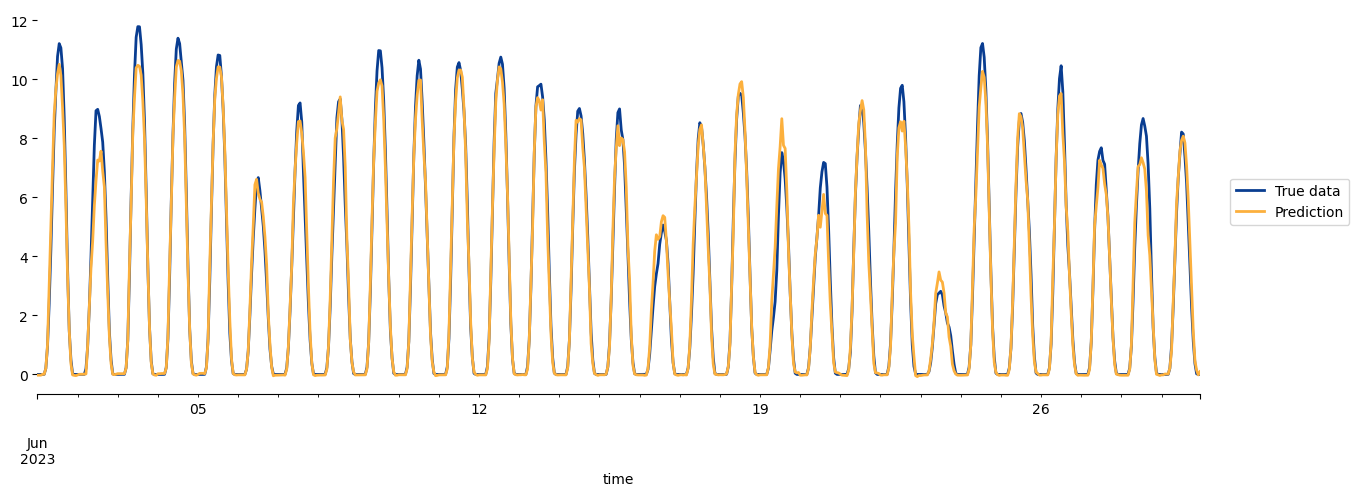

In [14]:
if PAST:
    plot_start = "2023-06-01"
    plot_end = "2023-06-30"

    gen_type = "Solar"

    true_df = pd.DataFrame()
    true_df["True data"] = generation_df[gen_type]/1000
    pred_df = pd.DataFrame()
    pred_df["Prediction"] = pred_generation_df[gen_type]/1000

    plot_predictions_2(true_df, pred_df, plot_start, plot_end, linestyle="-")

### Wind onshore

##### Get facilities and clusters

In [15]:
load_version = "20230704"
wind_onshore_df = pd.read_parquet(f"{load_path}/MaStR_data/wind_onshore_MaStR_{load_version}.parquet")
wind_onshore_cluster_centers = pd.read_parquet(f"{load_path}/MaStR_data/wind_onshore_clusters_100_{load_version}.parquet")

##### Get weather data

In [17]:
LOAD_FROM_FILE = 1
if LOAD_FROM_FILE:
    wind_onshore_weather_df = pd.read_parquet(f"{save_path}/weather/wind_onshore/100_clusters/weather_data_weighted_avg.parquet")
else:
    wind_onshore_weather_df = get_weather_data(cluster_df=wind_onshore_cluster_centers, 
                                        save_path=save_path, 
                                        energy_type="wind_onshore", 
                                        start=start.strftime("%Y-%m-%d"),
                                        end=(end-timedelta(days=1)).strftime("%Y-%m-%d"),
                                        timezone=timezone)

Retrieving weather data...
Something went wrong for cluster 59. Skipping cluster...
100/99
Done!


##### Aggregate data

In [18]:
# Get aggregate df
wind_onshore_test_df = aggregate_data(wind_onshore_df, wind_onshore_weather_df)

# Save df
start_date = wind_onshore_test_df.index[0].strftime('%Y%m%d')
end_date = wind_onshore_test_df.index[-1].strftime('%Y%m%d')
wind_onshore_test_df.to_parquet(f"{save_path}/wind_onshore_data_final_100_clusters_{start_date}-{end_date}.parquet")

##### Make prediction

In [19]:
# Load model
model = xgb.XGBRegressor()
model.load_model(f"{load_path}/models/onshore_xgboost_cv_5years_100clusters.json")

In [20]:
# Add/remove features
wind_onshore_test_df = add_datetime_features(wind_onshore_test_df)
wind_onshore_test_df = wind_onshore_test_df[list(model.feature_names_in_)]

In [21]:
wind_onshore_test_df, rmse, mape = predict_test(wind_onshore_test_df, model)
pred_generation_df["Wind Onshore"] = wind_onshore_test_df["prediction"]

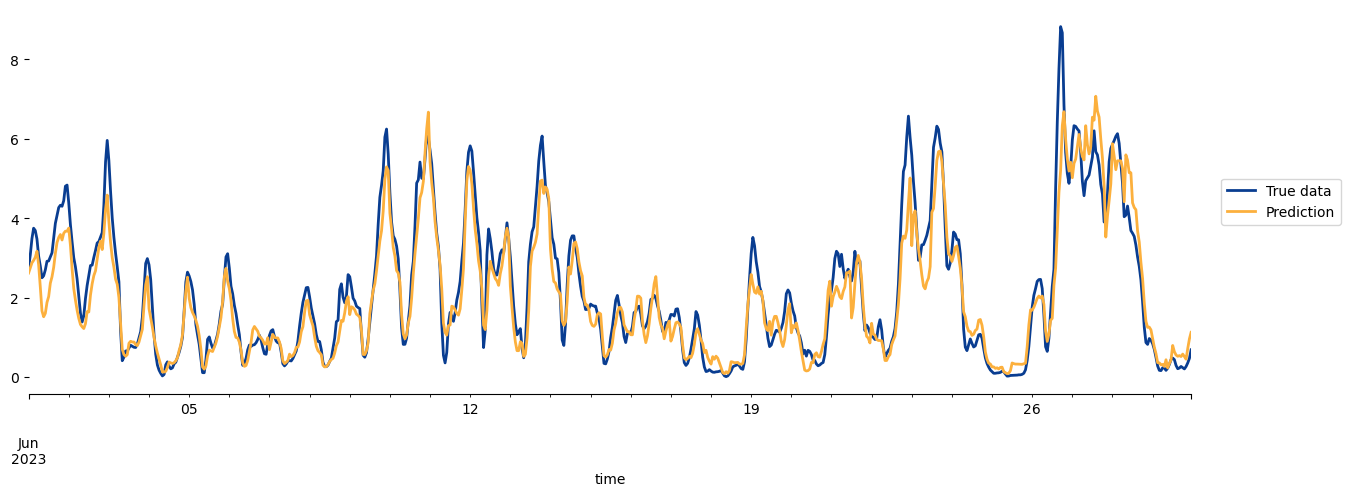

In [22]:
if PAST:
    plot_start = "2023-06-01"
    plot_end = "2023-06-30"

    gen_type = "Wind Onshore"

    true_df = pd.DataFrame()
    true_df["True data"] = generation_df[gen_type]/1000
    pred_df = pd.DataFrame()
    pred_df["Prediction"] = pred_generation_df[gen_type]/1000

    plot_predictions_2(true_df, pred_df, plot_start, plot_end, linestyle="-")

### Wind offshore

##### Get facilities and clusters

In [23]:
load_version = "20230704"
wind_offshore_df = pd.read_parquet(f"{load_path}/MaStR_data/wind_offshore_MaStR_{load_version}.parquet")
wind_offshore_cluster_centers = pd.read_parquet(f"{load_path}/MaStR_data/wind_offshore_clusters_6_{load_version}.parquet")

##### Get weather data

In [24]:
LOAD_FROM_FILE = 1
if LOAD_FROM_FILE:
    wind_offshore_weather_df = pd.read_parquet(f"{save_path}/weather/wind_offshore/6_clusters/weather_data_weighted_avg.parquet")
else:
    wind_offshore_weather_df = get_weather_data(cluster_df=wind_offshore_cluster_centers, 
                                        save_path=save_path, 
                                        energy_type="wind_offshore", 
                                        start=start.strftime("%Y-%m-%d"),
                                        end=(end-timedelta(days=1)).strftime("%Y-%m-%d"),
                                        timezone=timezone)

Retrieving weather data...
6/6
Done!


##### Aggregate data

In [25]:
# Get aggregate df
wind_offshore_test_df = aggregate_data(wind_offshore_df, wind_offshore_weather_df)

# Save df
start_date = wind_offshore_test_df.index[0].strftime('%Y%m%d')
end_date = wind_offshore_test_df.index[-1].strftime('%Y%m%d')
wind_offshore_test_df.to_parquet(f"{save_path}/wind_offshore_data_final_6_clusters_{start_date}-{end_date}.parquet")

##### Make prediction

In [26]:
# Load model
model = xgb.XGBRegressor()
model.load_model(f"{load_path}/models/offshore_xgboost_cv_5years_100clusters.json")

In [27]:
# Add/remove features
wind_offshore_test_df = add_datetime_features(wind_offshore_test_df)
wind_offshore_test_df = wind_offshore_test_df[list(model.feature_names_in_)]

In [28]:
wind_offshore_test_df, rmse, mape = predict_test(wind_offshore_test_df, model)
pred_generation_df["Wind Offshore"] = wind_offshore_test_df["prediction"]

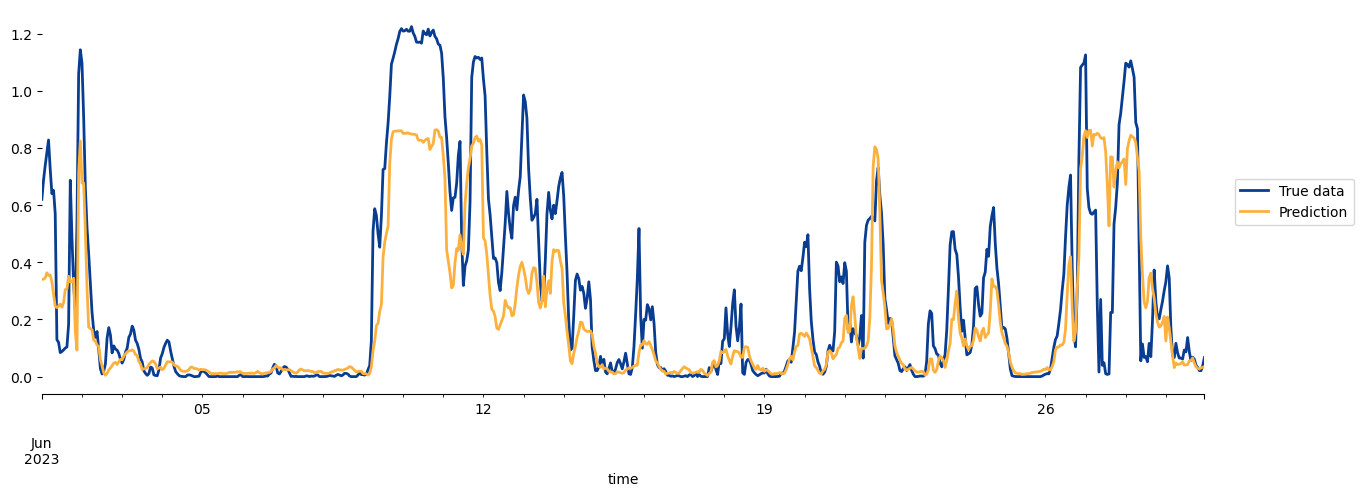

In [29]:
if PAST:
    plot_start = "2023-06-01"
    plot_end = "2023-06-30"

    gen_type = "Wind Offshore"

    true_df = pd.DataFrame()
    true_df["True data"] = generation_df[gen_type]/1000
    pred_df = pd.DataFrame()
    pred_df["Prediction"] = pred_generation_df[gen_type]/1000

    plot_predictions_2(true_df, pred_df, plot_start, plot_end, linestyle="-")

## 2. Predictions based on datetime features only

### Other renewables

##### Aggregate data

In [30]:
other_renewables_test_df = pd.DataFrame(index=pred_generation_df.index)

# Save df
start_date = other_renewables_test_df.index[0].strftime('%Y%m%d')
end_date = other_renewables_test_df.index[-1].strftime('%Y%m%d')
other_renewables_test_df.to_parquet(f"{save_path}/other_renewables_data_final_{start_date}-{end_date}.parquet")

##### Make prediction

In [31]:
# Load model
model = xgb.XGBRegressor()
model.load_model(f"{load_path}/models/other_renewables_xgboost_cv_5years_100clusters.json")

In [32]:
# Add/remove features
other_renewables_test_df = add_datetime_features(other_renewables_test_df)
other_renewables_test_df = other_renewables_test_df[list(model.feature_names_in_)]

In [33]:
other_renewables_test_df, rmse, mape = predict_test(other_renewables_test_df, model)
pred_generation_df["Other renewables"] = other_renewables_test_df["prediction"]

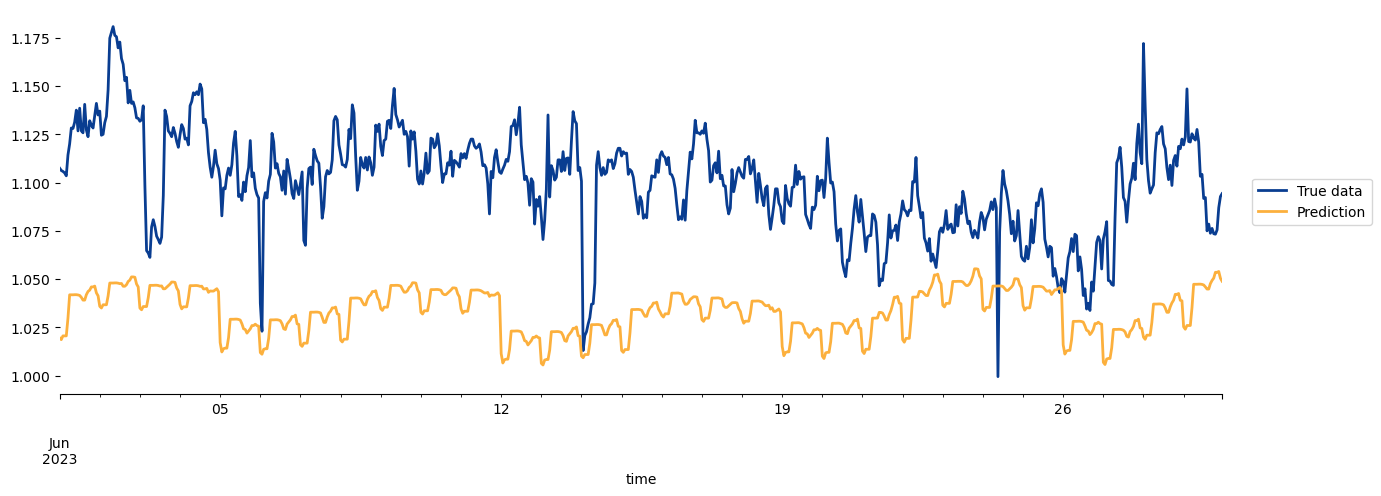

In [34]:
if PAST:
    plot_start = "2023-06-01"
    plot_end = "2023-06-30"

    gen_type = "Other renewables"

    true_df = pd.DataFrame()
    true_df["True data"] = generation_df[gen_type]/1000
    pred_df = pd.DataFrame()
    pred_df["Prediction"] = pred_generation_df[gen_type]/1000

    plot_predictions_2(true_df, pred_df, plot_start, plot_end, linestyle="-")

### Consumption

##### Aggregate data

In [35]:
consumption_test_df = pd.DataFrame(index=pred_generation_df.index)

# Save df
start_date = consumption_test_df.index[0].strftime('%Y%m%d')
end_date = consumption_test_df.index[-1].strftime('%Y%m%d')
consumption_test_df.to_parquet(f"{save_path}/consumption_data_final_{start_date}-{end_date}.parquet")

##### Make prediction

In [36]:
# Load model
model = xgb.XGBRegressor()
model.load_model(f"{load_path}/models/consumption_xgboost_cv_5years_100clusters.json")

In [37]:
# Add/remove features
consumption_test_df = add_datetime_features(consumption_test_df)
consumption_test_df = consumption_test_df[list(model.feature_names_in_)]

In [38]:
consumption_test_df, rmse, mape = predict_test(consumption_test_df, model)
pred_consumption_df["Gesamtnetzlast"] = consumption_test_df["prediction"]

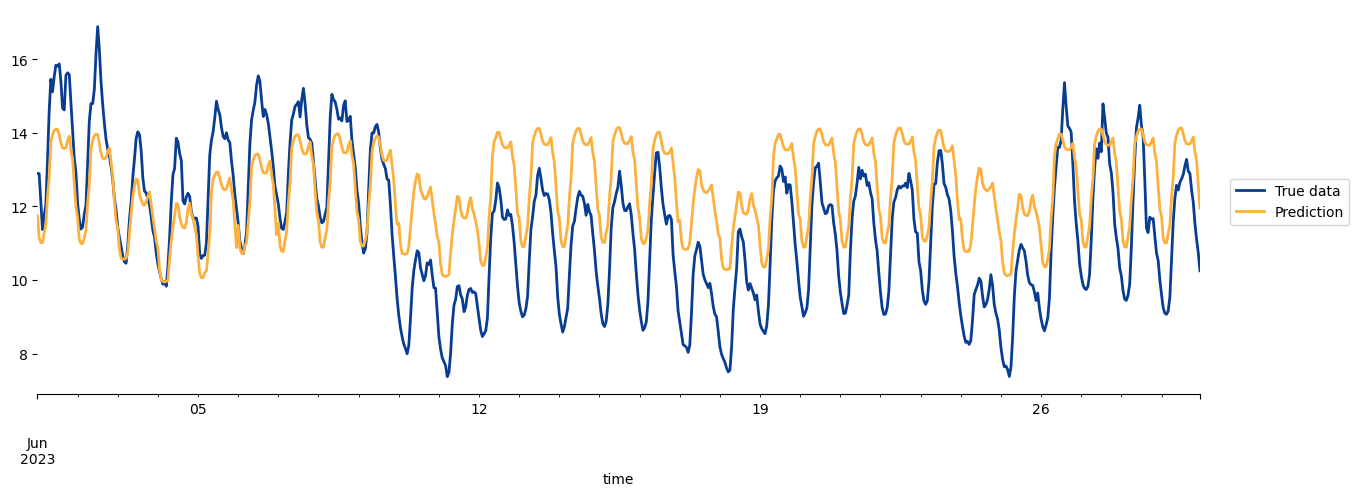

In [40]:
if PAST:
    plot_start = "2023-06-01"
    plot_end = "2023-06-30"

    plot_col = "Gesamtnetzlast"

    true_df = pd.DataFrame()
    true_df["True data"] = consumption_df[plot_col]/1000
    pred_df = pd.DataFrame()
    pred_df["Prediction"] = pred_consumption_df[plot_col]/1000

    plot_predictions_2(true_df, pred_df, plot_start, plot_end, linestyle="-")

## 3. Fossils: Predictions based on renewables and consumption
- Brown coal
- Hard coal
- Gas
- Other Fossils
- Hydro Pumped Storage

### Brown coal

##### Aggregate data

In [41]:
brown_coal_test_df = pred_generation_df[["Solar", "Wind Onshore", "Wind Offshore"]].copy()
brown_coal_test_df["total_consumption"] = pred_consumption_df["Gesamtnetzlast"]

# Save df
start_date = brown_coal_test_df.index[0].strftime('%Y%m%d')
end_date = brown_coal_test_df.index[-1].strftime('%Y%m%d')
brown_coal_test_df.to_parquet(f"{save_path}/brown_coal_data_final_{start_date}-{end_date}.parquet")

##### Make prediction

In [42]:
# Load model
model = xgb.XGBRegressor()
model.load_model(f"{load_path}/models/brown_coal_xgboost_cv_5years_100clusters.json")

In [43]:
# Add/remove features
brown_coal_test_df = add_datetime_features(brown_coal_test_df)
brown_coal_test_df = brown_coal_test_df[list(model.feature_names_in_)]

In [44]:
brown_coal_test_df, rmse, mape = predict_test(brown_coal_test_df, model)
pred_generation_df["Fossil Brown coal/Lignite"] = brown_coal_test_df["prediction"]

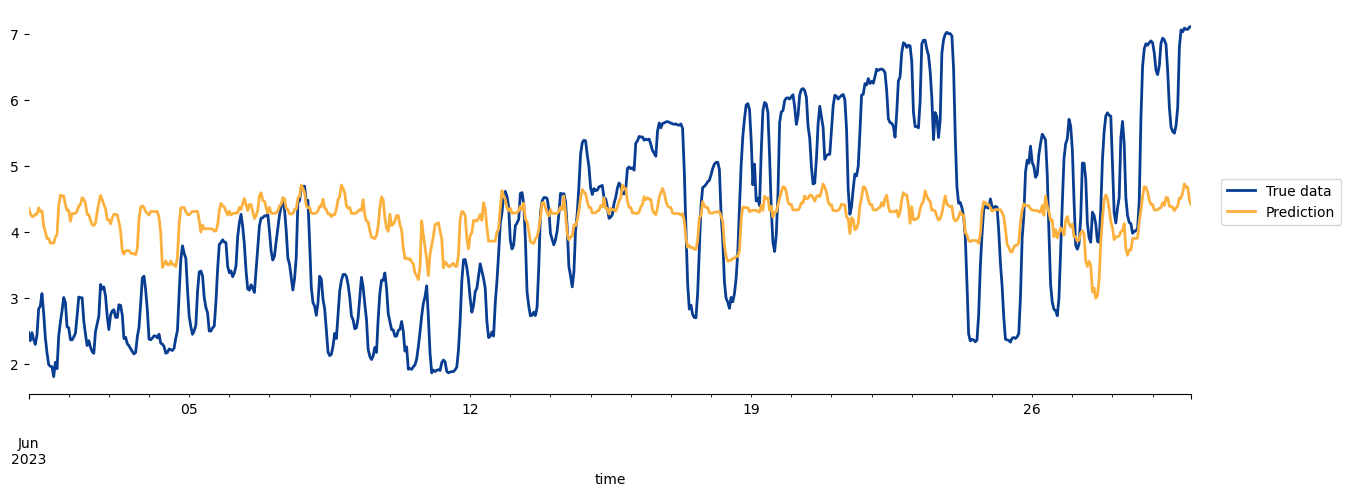

In [45]:
if PAST:
    plot_start = "2023-06-01"
    plot_end = "2023-06-30"

    gen_type = "Fossil Brown coal/Lignite"

    true_df = pd.DataFrame()
    true_df["True data"] = generation_df[gen_type]/1000
    pred_df = pd.DataFrame()
    pred_df["Prediction"] = pred_generation_df[gen_type]/1000

    plot_predictions_2(true_df, pred_df, plot_start, plot_end, linestyle="-")

### Hard coal

##### Aggregate data

In [46]:
hard_coal_test_df = pred_generation_df[["Solar", "Wind Onshore", "Wind Offshore"]].copy()
hard_coal_test_df["total_consumption"] = pred_consumption_df["Gesamtnetzlast"]

# Save df
start_date = hard_coal_test_df.index[0].strftime('%Y%m%d')
end_date = hard_coal_test_df.index[-1].strftime('%Y%m%d')
hard_coal_test_df.to_parquet(f"{save_path}/hard_coal_data_final_{start_date}-{end_date}.parquet")

##### Make prediction

In [47]:
# Load model
model = xgb.XGBRegressor()
model.load_model(f"{load_path}/models/hard_coal_xgboost_cv_5years_100clusters.json")

In [48]:
# Add/remove features
hard_coal_test_df = add_datetime_features(hard_coal_test_df)
hard_coal_test_df = hard_coal_test_df[list(model.feature_names_in_)]

In [49]:
hard_coal_test_df, rmse, mape = predict_test(hard_coal_test_df, model)
pred_generation_df["Fossil Hard coal"] = hard_coal_test_df["prediction"]

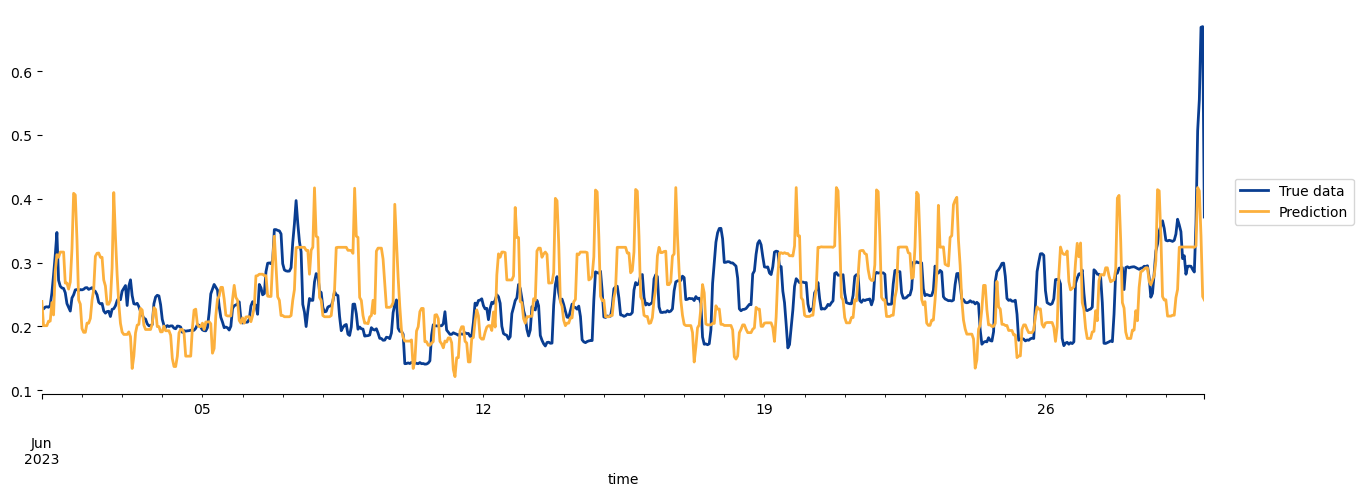

In [50]:
if PAST:
    plot_start = "2023-06-01"
    plot_end = "2023-06-30"

    gen_type = "Fossil Hard coal"

    true_df = pd.DataFrame()
    true_df["True data"] = generation_df[gen_type]/1000
    pred_df = pd.DataFrame()
    pred_df["Prediction"] = pred_generation_df[gen_type]/1000

    plot_predictions_2(true_df, pred_df, plot_start, plot_end, linestyle="-")

### Gas

##### Aggregate data

In [51]:
gas_test_df = pred_generation_df[["Solar", "Wind Onshore", "Wind Offshore"]].copy()
gas_test_df["total_consumption"] = pred_consumption_df["Gesamtnetzlast"]

# Save df
start_date = gas_test_df.index[0].strftime('%Y%m%d')
end_date = gas_test_df.index[-1].strftime('%Y%m%d')
gas_test_df.to_parquet(f"{save_path}/gas_data_final_{start_date}-{end_date}.parquet")

##### Make prediction

In [52]:
# Load model
model = xgb.XGBRegressor()
model.load_model(f"{load_path}/models/gas_xgboost_cv_5years_100clusters.json")

In [53]:
# Add/remove features
gas_test_df = add_datetime_features(gas_test_df)
gas_test_df = gas_test_df[list(model.feature_names_in_)]

In [54]:
gas_test_df, rmse, mape = predict_test(gas_test_df, model)
pred_generation_df["Fossil Gas"] = gas_test_df["prediction"]

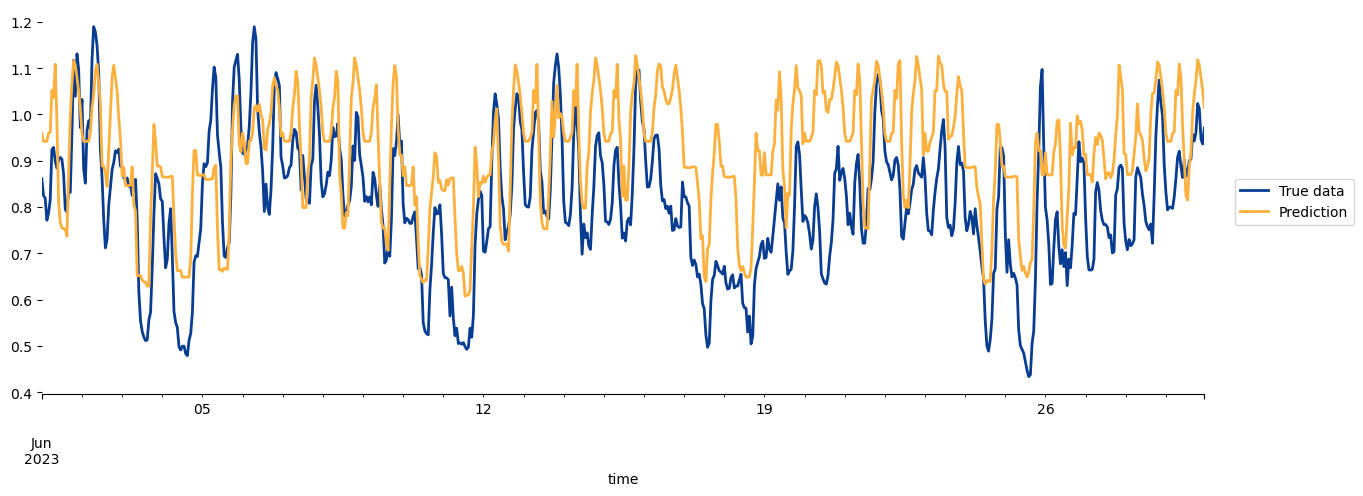

In [55]:
if PAST:
    plot_start = "2023-06-01"
    plot_end = "2023-06-30"

    gen_type = "Fossil Gas"

    true_df = pd.DataFrame()
    true_df["True data"] = generation_df[gen_type]/1000
    pred_df = pd.DataFrame()
    pred_df["Prediction"] = pred_generation_df[gen_type]/1000

    plot_predictions_2(true_df, pred_df, plot_start, plot_end, linestyle="-")

### Other Fossils

##### Aggregate data

In [56]:
other_fossils_test_df = pred_generation_df[["Solar", "Wind Onshore", "Wind Offshore"]].copy()
other_fossils_test_df["total_consumption"] = pred_consumption_df["Gesamtnetzlast"]

# Save df
start_date = other_fossils_test_df.index[0].strftime('%Y%m%d')
end_date = other_fossils_test_df.index[-1].strftime('%Y%m%d')
other_fossils_test_df.to_parquet(f"{save_path}/other_fossils_data_final_{start_date}-{end_date}.parquet")

##### Make prediction

In [57]:
# Load model
model = xgb.XGBRegressor()
model.load_model(f"{load_path}/models/other_fossils_xgboost_cv_5years_100clusters.json")

In [58]:
# Add/remove features
other_fossils_test_df = add_datetime_features(other_fossils_test_df)
other_fossils_test_df = other_fossils_test_df[list(model.feature_names_in_)]

In [59]:
other_fossils_test_df, rmse, mape = predict_test(other_fossils_test_df, model)
pred_generation_df["Other fossils"] = other_fossils_test_df["prediction"]

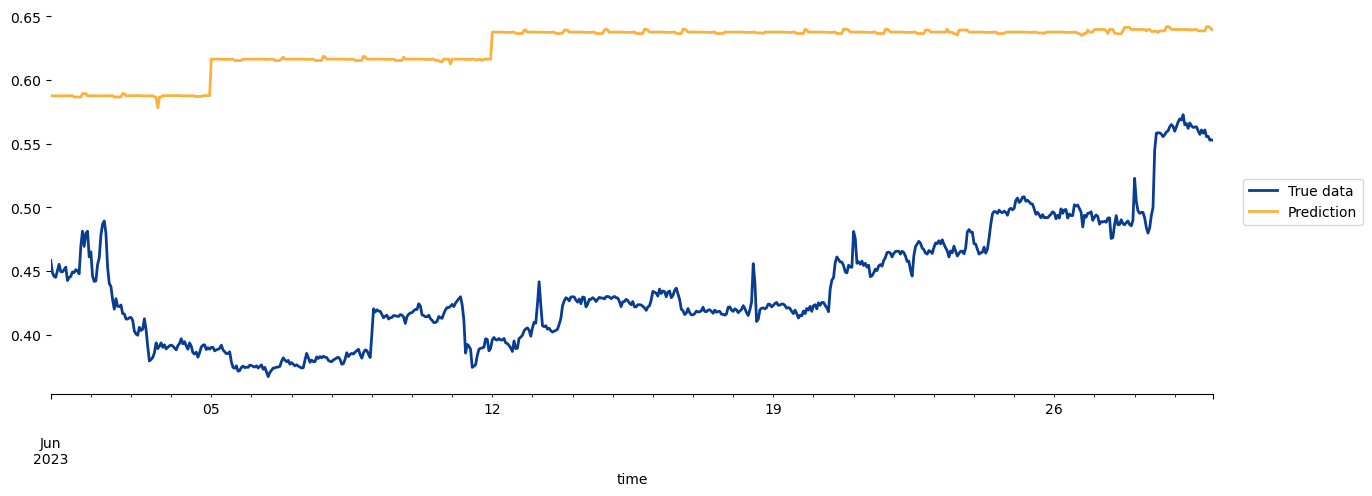

In [60]:
if PAST:
    plot_start = "2023-06-01"
    plot_end = "2023-06-30"

    gen_type = "Other fossils"

    true_df = pd.DataFrame()
    true_df["True data"] = generation_df[gen_type]/1000
    pred_df = pd.DataFrame()
    pred_df["Prediction"] = pred_generation_df[gen_type]/1000

    plot_predictions_2(true_df, pred_df, plot_start, plot_end, linestyle="-")

### Hydro Pumped Storage

##### Aggregate data

In [61]:
hydro_pumped_storage_test_df = pred_generation_df[["Solar", "Wind Onshore", "Wind Offshore"]].copy()
hydro_pumped_storage_test_df["total_consumption"] = pred_consumption_df["Gesamtnetzlast"]

# Save df
start_date = hydro_pumped_storage_test_df.index[0].strftime('%Y%m%d')
end_date = hydro_pumped_storage_test_df.index[-1].strftime('%Y%m%d')
hydro_pumped_storage_test_df.to_parquet(f"{save_path}/hydro_pumped_storage_data_final_{start_date}-{end_date}.parquet")

##### Make prediction

In [62]:
# Load model
model = xgb.XGBRegressor()
model.load_model(f"{load_path}/models/hydro_pumped_storage_xgboost_cv_5years_100clusters.json")

In [63]:
# Add/remove features
hydro_pumped_storage_test_df = add_datetime_features(hydro_pumped_storage_test_df)
hydro_pumped_storage_test_df = hydro_pumped_storage_test_df[list(model.feature_names_in_)]

In [64]:
hydro_pumped_storage_test_df, rmse, mape = predict_test(hydro_pumped_storage_test_df, model)
pred_generation_df["Hydro Pumped Storage"] = hydro_pumped_storage_test_df["prediction"]

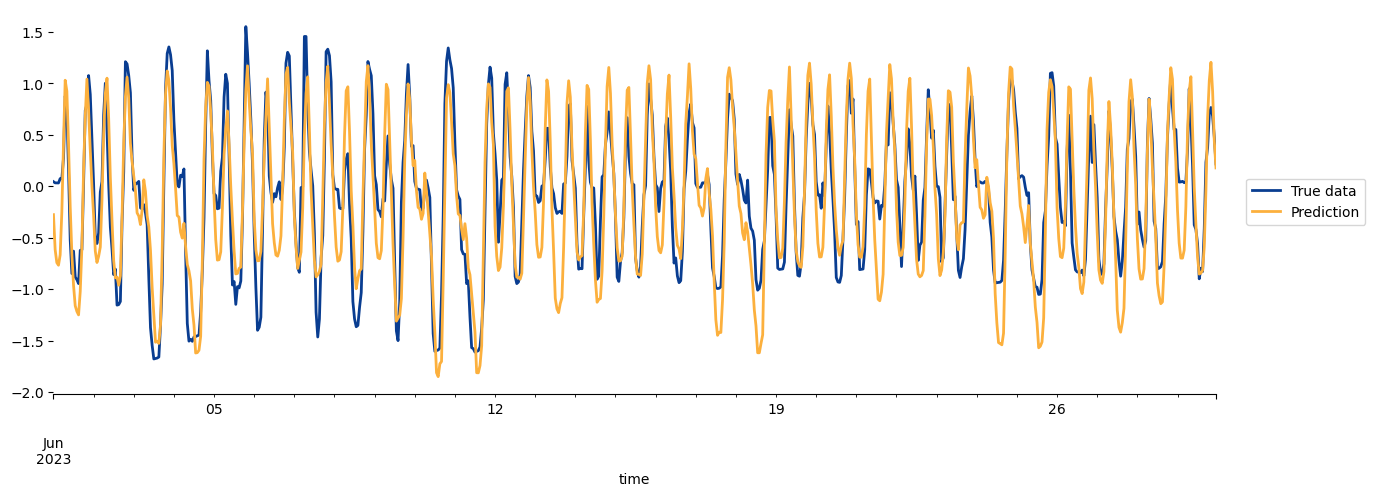

In [66]:
if PAST:
    plot_start = "2023-06-01"
    plot_end = "2023-06-30"

    gen_type = "Hydro Pumped Storage"

    true_df = pd.DataFrame()
    true_df["True data"] = generation_df[gen_type]/1000
    pred_df = pd.DataFrame()
    pred_df["Prediction"] = pred_generation_df[gen_type]/1000

    plot_predictions_2(true_df, pred_df, plot_start, plot_end, linestyle="-")

## 4. Prediction based on all generation types and consumption

### Price

##### Aggregate data

In [67]:
price_test_df = pred_generation_df.copy()
price_test_df["total_consumption"] = pred_consumption_df["Gesamtnetzlast"]

# Save df
start_date = price_test_df.index[0].strftime('%Y%m%d')
end_date = price_test_df.index[-1].strftime('%Y%m%d')
price_test_df.to_parquet(f"{save_path}/price_data_final_{start_date}-{end_date}.parquet")

##### Make prediction

In [68]:
# Load model
model = xgb.XGBRegressor()
model.load_model(f"{load_path}/models/price_xgboost_cv_5years_100clusters.json")

In [69]:
# Add/remove features
price_test_df = add_datetime_features(price_test_df)
price_test_df = price_test_df[list(model.feature_names_in_)]

In [70]:
price_test_df, rmse, mape = predict_test(price_test_df, model)
pred_price_df["prices"] = price_test_df["prediction"]

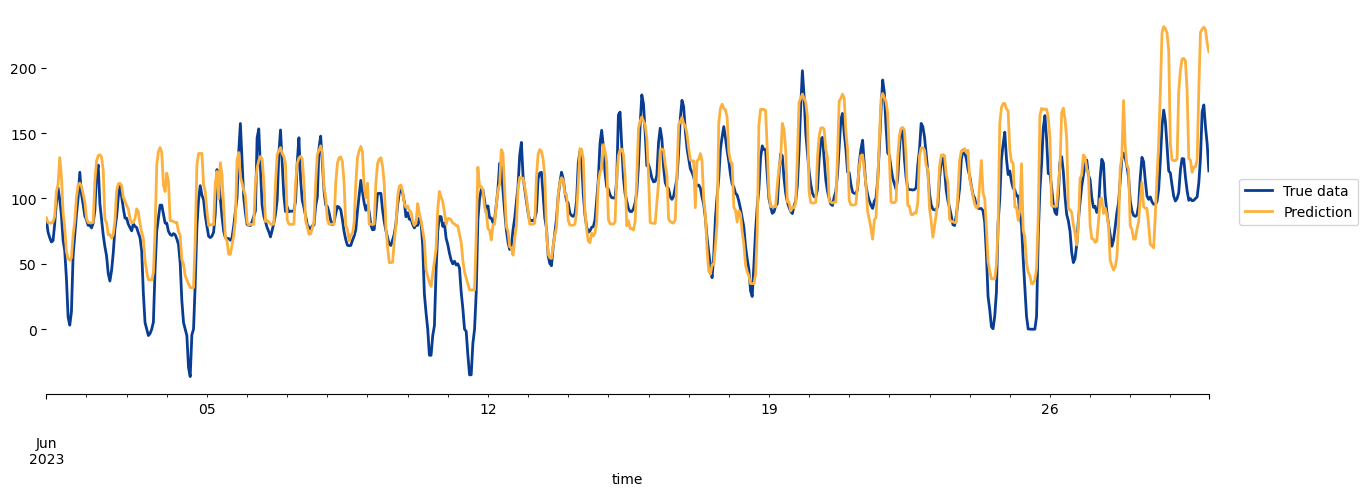

In [72]:
if PAST:
    plot_start = "2023-06-01"
    plot_end = "2023-06-30"

    plot_col = "prices"

    true_df = pd.DataFrame()
    true_df["True data"] = price_df[plot_col]
    pred_df = pd.DataFrame()
    pred_df["Prediction"] = pred_price_df[plot_col]

    plot_predictions_2(true_df, pred_df, plot_start, plot_end, linestyle="-")

## 5. Compute CO2 emissions

In [73]:
pred_emission_df = compute_emissions(pred_generation_df)

## Plot

In [74]:
color_dict = {
    "Fossil Brown coal/Lignite": "#bfb282", 
    "Fossil Gas": "#9e8060", 
    "Fossil Hard coal": "#706962",
    "Hydro Pumped Storage": "#567189", 
    "Solar": "#ffdd00", 
    "Wind Offshore": "#146C94", 
    "Wind Onshore": "#19A7CE",
    "Other renewables": "#32a852", 
    "Other fossils": "#9c9c9c",
}

#### With consumption

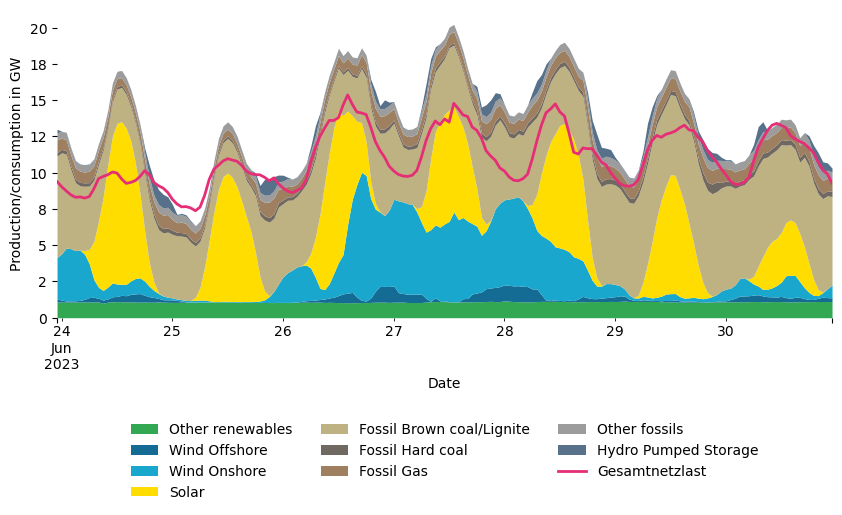

In [75]:
# Actual
if PAST:
    plot_generation(generation_df, color_dict, cons_df=consumption_df, days=7)

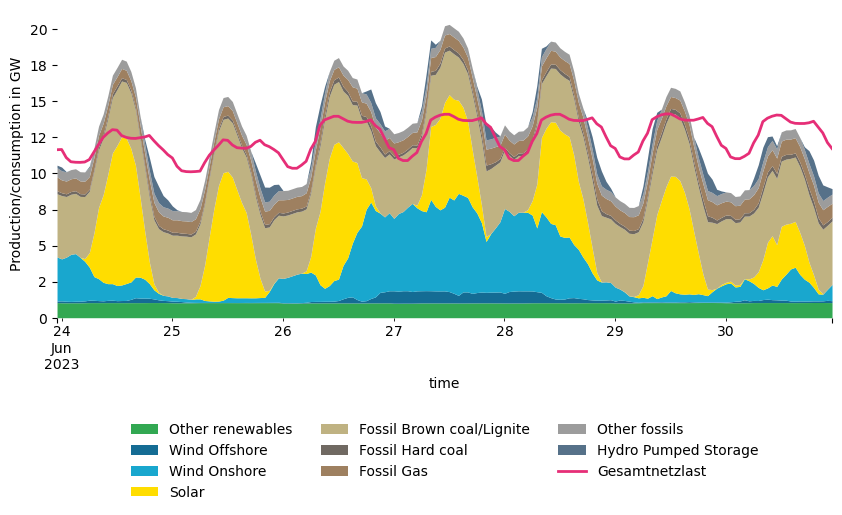

In [76]:
# Predicted
plot_generation(pred_generation_df, color_dict, cons_df=pred_consumption_df, days=7)

#### With emissions

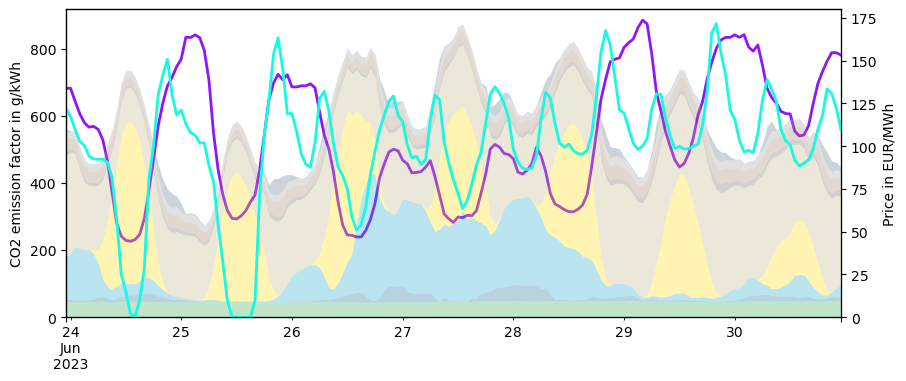

In [77]:
# Actual
if PAST:
    plot_generation(generation_df, color_dict, em_df=emission_df, pr_df=price_df, days=7)

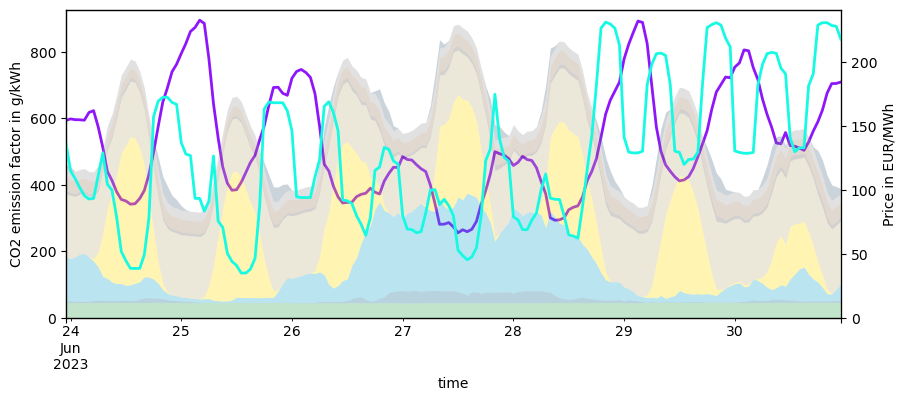

In [78]:
# Prediction
plot_generation(pred_generation_df, color_dict, em_df=pred_emission_df, pr_df=pred_price_df, days=7)